In [1]:
!pip install openpyxl
!pip install pandas-gbq -U
!pip install tableone
!pip install pydata-google-auth
!pip install python-docx


In [2]:
import pandas as pd
from tableone import TableOne
import sklearn as sk
from xgboost import XGBClassifier, XGBRegressor
import numpy as np
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, recall_score, precision_score, f1_score, balanced_accuracy_score
from sklearn.metrics import r2_score, mean_absolute_error
from fairlearn.metrics import equalized_odds_ratio, demographic_parity_ratio
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import warnings
import shap
from tableone import tableone
from matplotlib import pyplot as plt
from lightgbm import LGBMClassifier
import pydata_google_auth
import seaborn as sns
from imblearn.pipeline import Pipeline
import pandas_gbq
from sklearn.preprocessing import (
    StandardScaler, 
    OneHotEncoder, 
    OrdinalEncoder, 
    PowerTransformer, 
    QuantileTransformer, 
    RobustScaler, 
    MinMaxScaler
)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector


warnings.filterwarnings("ignore")

/Users/lnazer/anaconda3/lib/python3.11/site-packages/shap/plots/colors/_colorconv.py:819: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if np.issubdtype(dtype_in, np.dtype(dtype).type):
/Users/lnazer/anaconda3/lib/python3.11/site-packages/shap/plots/colors/_colorconv.py:819: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if np.issubdtype(dtype_in, np.dtype(dtype).type):
/Users/lnazer/anaconda3/lib/python3.11/site-packages/shap/plots/colors/_colorconv.py:819: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if np.issubdtype(dtype_in, np.dtype(dtype).type):
/Users/lnazer/anaconda3/lib/python3.11/site-packages/shap/plots/colors/_colorconv.py:819: DeprecationWarning: Converting `np

In [3]:
credentials = pydata_google_auth.get_user_credentials(['https://www.googleapis.com/auth/cloud-platform'],)
project = 'capacheiv'
pandas_gbq.context.credentials = credentials

In [4]:
query = ""
for fn in ['icustays', 'apache_vars', 'apache_pt_results', 'sepsis']:
    with open('sql_copy/'+fn+'.sql', 'r') as file:
        query += file.read()
query += "select * from sepsis"
project = 'capacheiv'

gbq_data_15_16 = pd.read_gbq(query, dialect='standard', project_id=project)

In [5]:
query = ""
for fn in ['icustays', 'apache_vars', 'apache_pt_results', 'sepsis']:
    with open('sql_new/'+fn+'.sql', 'r') as file:
        query += file.read()
query += "select * from sepsis"
project = 'capacheiv'

gbq_data_17_21 = pd.read_gbq(query, dialect='standard', project_id=project)

In [32]:
df_old = gbq_data_15_16
df_new = gbq_data_17_21

In [33]:
df_new_no_duplicates = df_new[~df_new['uniquepid'].isin(df_old['uniquepid'])] 

In [34]:
df_pre_clean = pd.concat([df_old, df_new_no_duplicates], axis=0, ignore_index=True)

In [35]:
df_first_admission = df_pre_clean[df_pre_clean['HOSP_NUM'] == 1]

In [36]:
df = df_first_admission[df_first_admission['has_sepsis'] == 1]

In [37]:
print(f"full: {len(df_new_no_duplicates)}\n"
      f"first_admissions: {len(df_first_admission)}\n"
      f"sepsis: {len(df)}\n")


full: 100047
first_admissions: 156921
sepsis: 27141



In [94]:
df['set'] = df['hospitaldischargeyear'].apply(
    lambda x: 'train' if x in [2014] else(
        'val_15' if x == 2015 else(
            'val_20' if x == 2020 else(
              'val_21' if x==2021 else np.nan
            ) 
        )
    )
)



In [95]:
df.head()

,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,...,icu_mortality,has_sepsis,hospitaladmityear,hospitaladmittime,hospitaldischargetime,unitadmityear,unitadmittime,unitdischargeyear,unitdischargetime,set
0,478979,406058,Female,85,Hispanic,142,256,"Sepsis, unknown",154.9,19:32:00,...,0,1,<NA>,NaN,NaN,<NA>,NaN,<NA>,NaN,train
4,528966,446712,Male,55,Caucasian,142,256,"Sepsis, renal/UTI (including bladder)",185.4,00:37:00,...,0,1,<NA>,NaN,NaN,<NA>,NaN,<NA>,NaN,train
5,484211,410302,Female,71,Hispanic,142,256,"Sepsis, renal/UTI (including bladder)",154.9,09:46:00,...,0,1,<NA>,NaN,NaN,<NA>,NaN,<NA>,NaN,train
7,501432,424397,Female,60,Caucasian,142,256,"Sepsis, renal/UTI (including bladder)",185.4,22:14:00,...,0,1,<NA>,NaN,NaN,<NA>,NaN,<NA>,NaN,train
13,505500,427734,Male,81,Hispanic,142,256,"Sepsis, GI",165.1,01:06:00,...,0,1,<NA>,NaN,NaN,<NA>,NaN,<NA>,NaN,val_15


In [101]:
df['los_7d'] = df['hosp_los'].apply(lambda x: 1 if x >= 7 else 0)
# df['ethnicity'] = df['ethnicity'].replace({'Black/African American': 'African American',
#                                            '': 'Missing',
#                                            'Native American':'Indigenous/Native'})
df['ethnicity'] = df['ethnicity'].replace({'Black/African American': 'African American',
                                           'Indigenous/Native': 'Minority',
                                           '': 'Minority',
                                           'Asian': 'Minority',
                                           'Hispanic': 'Minority',
                                           'Native American':'Minorty'})
df = df.fillna({'ethnicity':'Missing'})

In [98]:
df.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
Index: 27203 entries, 0 to 157302
Data columns (total 73 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   patientunitstayid          27203 non-null  Int64  
 1   patienthealthsystemstayid  27203 non-null  Int64  
 2   gender                     27203 non-null  object 
 3   age                        27203 non-null  object 
 4   ethnicity                  27203 non-null  object 
 5   hospitalid                 27203 non-null  Int64  
 6   wardid                     27203 non-null  Int64  
 7   apacheadmissiondx          27189 non-null  object 
 8   admissionheight            26961 non-null  float64
 9   hospitaladmittime24        27203 non-null  object 
 10  hospitaladmitoffset        27203 non-null  Int64  
 11  hospitaladmitsource        24441 non-null  object 
 12  hospitaldischargeyear      27203 non-null  Int64  
 13  hospitaldischargetime24    27203 non-null  object 

<Axes: >

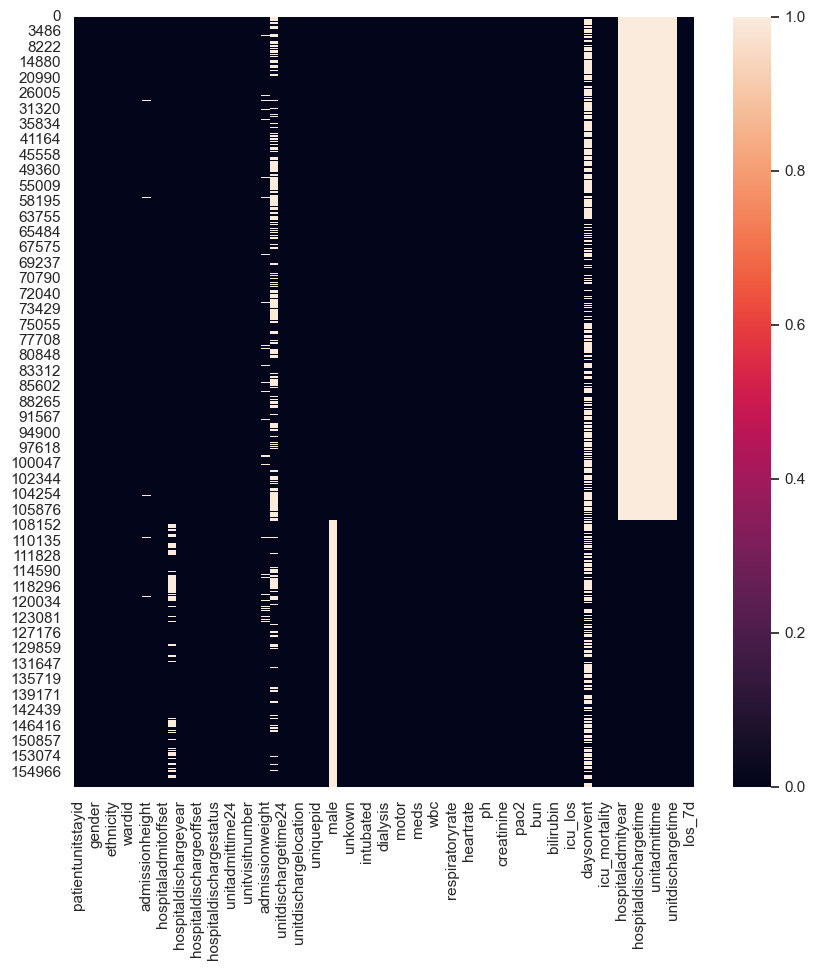

In [99]:
plt.figure(figsize=(10,10))
sns.heatmap(df.isna().astype(np.int64))

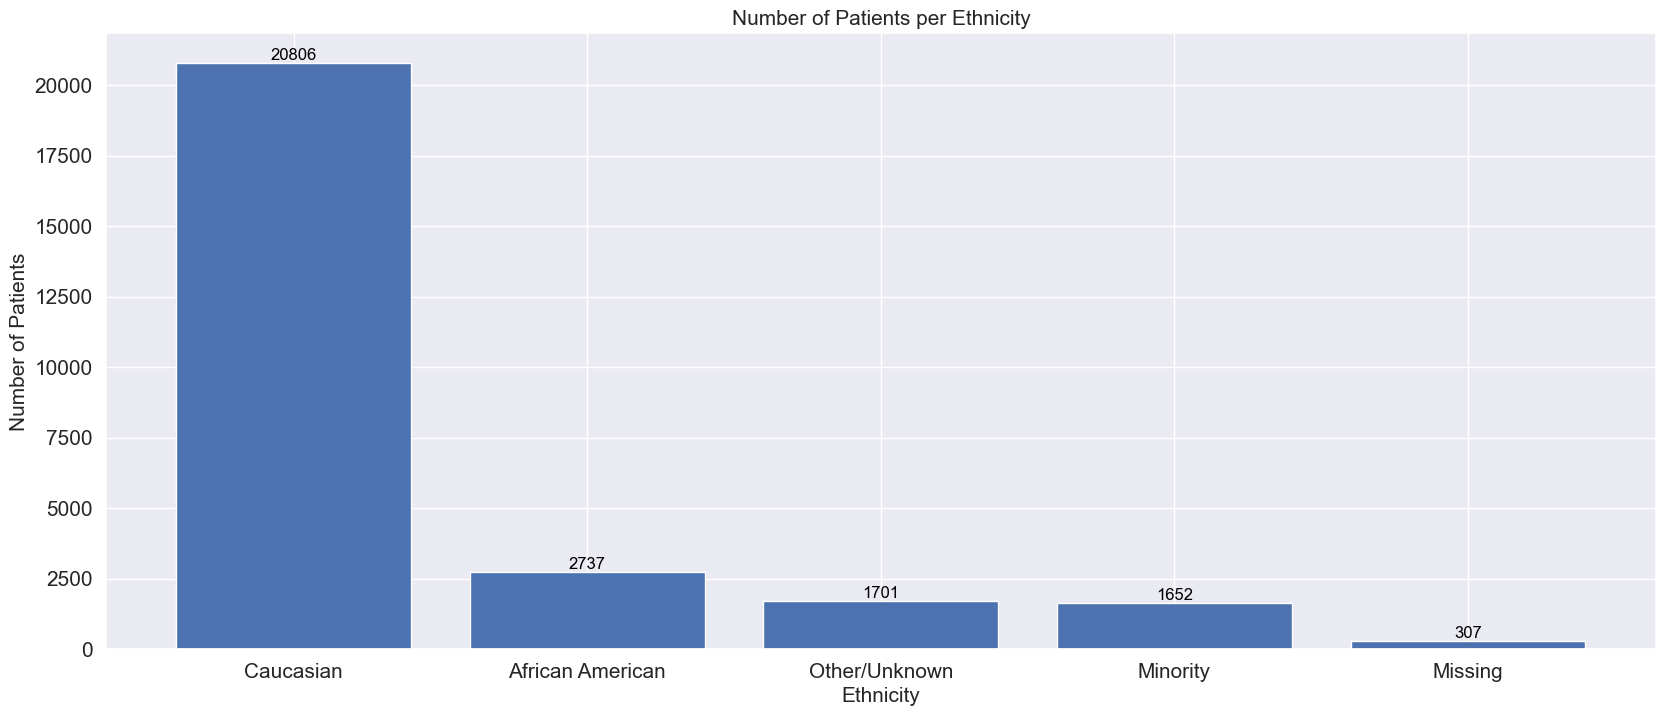

In [102]:
ethincity_counts = df['ethnicity'].value_counts()

plt.figure(figsize=(20, 8)) 
bars = plt.bar(ethincity_counts.index, ethincity_counts.values)

plt.title('Number of Patients per Ethnicity', fontsize=15)  
plt.xlabel('Ethnicity', fontsize=15)
plt.ylabel('Number of Patients', fontsize=15)
plt.xticks(fontsize=15) 
plt.yticks(fontsize=15)

# Adding the values above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha='center', va='bottom', fontsize=12, color='black')

plt.show()


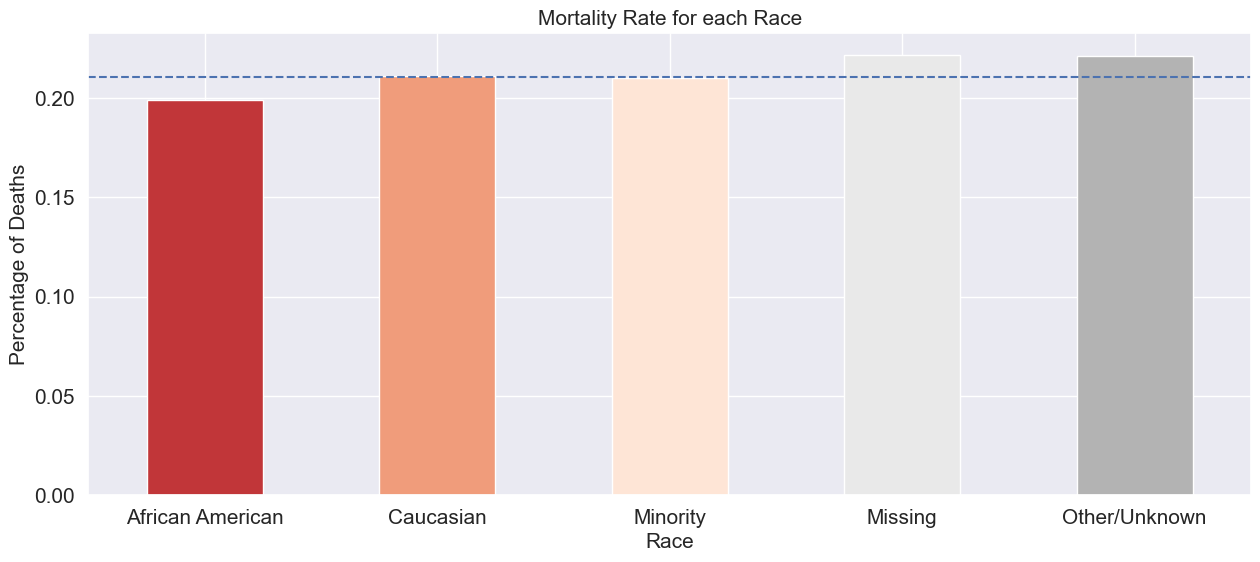

In [103]:
plt.figure(figsize=(15, 6))
df.groupby('ethnicity')['hosp_mortality'].mean().plot(kind='bar', color=sns.color_palette('RdGy'))

plt.xlabel('Race', fontsize=15)
plt.ylabel('Percentage of Deaths', fontsize=15)
plt.title('Mortality Rate for each Race', fontsize=15)
plt.axhline(y=df['hosp_mortality'].mean(), linestyle='--')

# Adjust the tick label sizes
plt.xticks(fontsize=15)
plt.xticks(rotation=0)

plt.yticks(fontsize=15)

# Show the plot
plt.show()


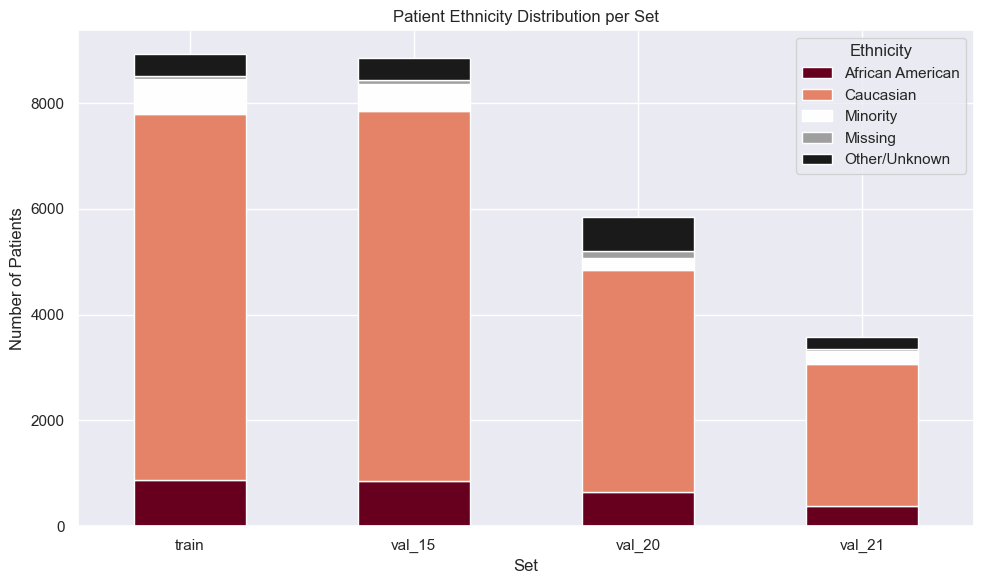

In [104]:
counts = df.groupby(['set', 'ethnicity']).size().unstack(fill_value=0)

# Plotting
counts.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='RdGy')

# Labels and legend
plt.title('Patient Ethnicity Distribution per Set')
plt.ylabel('Number of Patients')
plt.xlabel('Set')
plt.xticks(rotation=0)
plt.legend(title='Ethnicity')
plt.tight_layout()
plt.show()

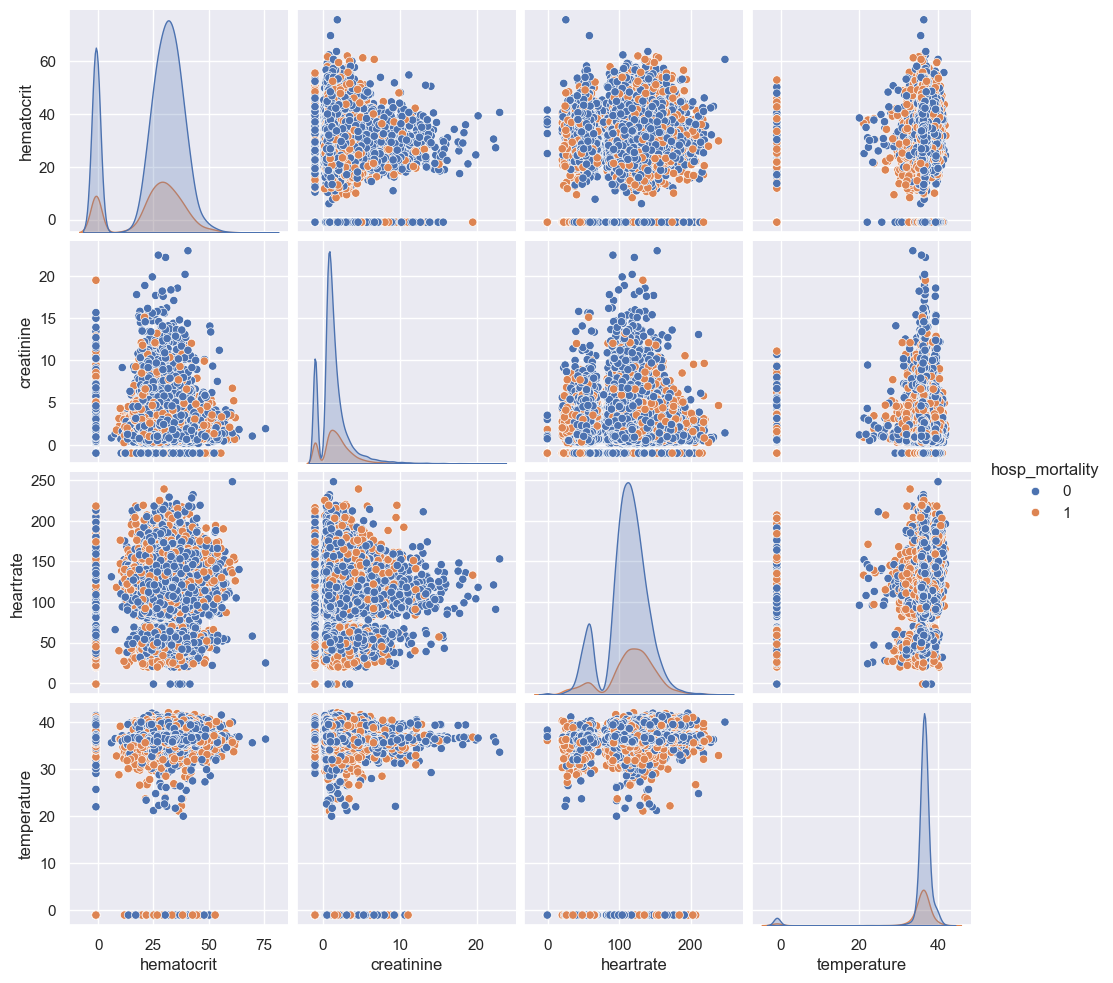

In [105]:
sns.set(font_scale=1)
sns.pairplot(df.loc[:,['hematocrit','creatinine','heartrate','temperature','hosp_mortality']],
             hue='hosp_mortality')

In [106]:
df = df.drop(columns=[ 'patientunitstayid', 'patienthealthsystemstayid', 'gender', 'age',
       'hospitalid', 'wardid', 'apacheadmissiondx',
       'admissionheight', 'hospitaladmittime24', 'hospitaladmitoffset',
       'hospitaladmitsource', 'hospitaldischargeyear',
       'hospitaldischargetime24', 'hospitaldischargeoffset',
       'hospitaldischargelocation', 'hospitaldischargestatus', 'unittype',
       'unitadmittime24', 'unitadmitsource', 'unitvisitnumber', 'unitstaytype',
       'admissionweight', 'dischargeweight', 'unitdischargetime24',
       'unitdischargeoffset', 'unitdischargelocation', 'unitdischargestatus',
       'uniquepid','HOSP_NUM', 'eyes', 'motor',
       'verbal', 'meds', 'icu_los', 'hosp_los',
       'daysonvent', 'icu_mortality', 'hospitaladmityear',
       'hospitaladmittime', 'hospitaldischargetime', 'unitadmityear',
       'unitadmittime', 'unitdischargeyear', 'unitdischargetime', 'has_sepsis', 'los_7d'])

In [107]:
tableone(df,
         groupby='set',
         columns=['hosp_mortality', 'ethnicity'],
         order={'hosp_mortality':[1,0]},
         limit={'hosp_mortality': 1},
        )

Grouped by set                                                                  
                                              Missing       Overall        train       val_15       val_20       val_21
n                                                             27203         8927         8847         5845         3584
hosp_mortality, n (%) 1                             0   5724 (21.0)  1816 (20.3)  1892 (21.4)  1133 (19.4)   883 (24.6)
ethnicity, n (%)      African American              0   2737 (10.1)    872 (9.8)    846 (9.6)   639 (10.9)   380 (10.6)
                      Caucasian                        20806 (76.5)  6927 (77.6)  6995 (79.1)  4203 (71.9)  2681 (74.8)
                      Minority                           1652 (6.1)    659 (7.4)    525 (5.9)    225 (3.8)    243 (6.8)
                      Missing                             307 (1.1)     54 (0.6)     73 (0.8)    139 (2.4)     41 (1.1)
                      Other/Unknown                      1701 (6.3)    415 (4.6)    408 (4.6)   639 (10.9)    239 (6.7)

In [108]:
def compute_metrics_long_format(y_true,
                                y_pred_proba,
                                seed,
                                target,
                                val_set,
                                sens_attributes,
                                c_test_sens
                               ):
    results = []
    
    for sens_attribute in sens_attributes:
        c_test = c_test_sens[sens_attribute]
    
        unique_classes = c_test.unique()
    
        metrics_list = [
            'AUROC',
            # 'AUPRC',
            'Accuracy',
            'Recall',
            # 'Precision',
            'F1-score',
            # 'Balanced Accuracy'
        ]
        
        functions_list = [
            roc_auc_score,
            # average_precision_score,
            accuracy_score,
            recall_score,
            # precision_score,
            f1_score,
            # balanced_accuracy_score
        ]
    
        for cls in unique_classes:
            idx = c_test == cls
            for metric, func in zip(metrics_list, functions_list):
                try:
                    value = func(y_true[idx], (y_pred_proba[idx] > 0.5).astype(int)) \
                                               if metric not in ['AUROC','AUPRC'] else func(y_true[idx], y_pred_proba[idx])
                except:
                    value = np.nan
                
                results.append({
                    'Task': target,
                    'Validation Set': val_set,
                    'Seed': seed,
                    'Attribute': sens_attribute,
                    'Class': cls,
                    'Metric': metric,
                    'Value': value
                })
    
        # Compute metrics for all classes combined    
        overall_metrics = {}
        for metric, func in zip(metrics_list, functions_list):
            overall_metrics[metric] = func(y_true, (y_pred_proba > 0.5).astype(float))\
                                           if metric not in ['AUROC','AUPRC'] else func(y_true, y_pred_proba)
    
        for metric, value in overall_metrics.items():
            results.append({
                'Task': target,
                'Validation Set': val_set,
                'Seed': seed,
                'Attribute': '',
                'Class': 'Overall',
                'Metric': metric,
                'Value': value
            })
    
        # # compute fairness metrics as well
        # fairness_metrics = {}
        
        # fairness_metrics_list = [
        #     'Demographic Parity Ratio',
        #     'Equalized Odds Ratio'
        # ]
        
        # fairness_functions_list = [
        #     demographic_parity_ratio,
        #     equalized_odds_ratio
        # ]
    
        # for metric, func in zip(fairness_metrics_list, fairness_functions_list):
        #     fairness_metrics[metric] = func(y_true=y_true,
        #                                     y_pred=(y_pred_proba > 0.5).astype(int),
        #                                     sensitive_features=c_test)
    
        # for metric, value in fairness_metrics.items():
        #     results.append({
        #         'Task': target,
        #         'Validation Set': val_set,
        #         'Seed': seed,
        #         'Attribute': sens_attribute,
        #         'Class': 'Overall',
        #         'Metric': metric,
        #         'Value': value
        #     })

    return pd.DataFrame(results)

In [109]:
def get_sample_weights(y_train):
    
    classes_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(y_train),
        y=y_train
    )
    
    sample_weights = np.ones(y_train.shape[0], dtype = 'float')
    for i, val in enumerate(y_train):
        sample_weights[i] = classes_weights[int(val)]

    return sample_weights

In [110]:
def train_model(df,
                features,
                target='hosp_mortality',
                model=XGBClassifier(),
               ):
    
    X_train = df.loc[df['set'] == 'train', features]
    y_train = df.loc[df['set'] == 'train', target]

    # Train, test, eval model with sample weights
    model.fit(X_train, y_train, sample_weight=get_sample_weights(y_train))
    
    return model


def test_model(df,
               features,
               metrics_all,
               model,
               target='hosp_mortality',
               val_set=['val_15', 'val_20', 'val_21'],
               sens_attributes=['ethnicity', 'region'],
               seed=42,
              ):


    X_test = df.loc[df['set'] == val_set, features]
    y_test = df.loc[df['set'] == val_set, target]
    
    np.random.seed(s)
    resample = np.random.randint(0, len(X_test), size=int(.8*len(X_test)))

    X_test = X_test.iloc[resample]
    y_test = y_test.iloc[resample]

    # classes of sensitive attributes in the test set
    c_test_sens = df.loc[df['set'] == val_set, sens_attributes].iloc[resample]

    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    metrics_fold = compute_metrics_long_format(y_test, y_pred_proba, seed,
                                               target, val_set, sens_attributes, 
                                               c_test_sens)

    metrics_all = pd.concat([metrics_all, metrics_fold], axis=0)

    return metrics_all.drop_duplicates()
    

In [111]:
def mean_ci_agg(df):
    mean = np.mean(df)
    se = np.std(df) / np.sqrt(len(df))
    ci_width = 1.96 * se
    lower_ci = mean - ci_width
    upper_ci = mean + ci_width
    return f"{mean:.3f} ({lower_ci:.3f} - {upper_ci:.3f})"

In [112]:
def compute_p_value(group):
    group_labels = group['Validation Set'].unique()
    group_values = [group[group['Validation Set'] == label]['Value'] for label in group_labels]
    
    _, p_value = ttest_ind(*group_values)  

    if p_value < .001:
        return '<.001'
    elif p_value < .01:
        return '<.01'
    else:
        return np.round(p_value, 3)

In [113]:
def calculate_md(group):
    group_labels = group['Validation Set'].unique()
    group_values = [group[group['Validation Set'] == label]['Value'] for label in group_labels]

    mean_diff = np.mean(group_values[1]) - np.mean(group_values[0])

    return mean_diff

In [114]:
def process_metrics(metrics_all):
    
    pivoted_metrics = metrics_all.pivot(
        index=['Seed', 'Metric', 'Attribute','Class'],
        columns=['Task','Validation Set'],
        values=['Value']
    ).groupby(['Metric', 'Attribute','Class',]) \
     .agg(mean_ci_agg) \
     .droplevel(0,axis=1)

    return pivoted_metrics
    
    p_values = metrics_all.groupby(['Task', 'Metric', 'Attribute', 'Class']) \
                          .apply(compute_p_value) \
                          .reset_index(name='p_value') \
                          .pivot(
                              columns='Task',
                              index=['Metric', 'Attribute', 'Class'],
                              values='p_value') \
                          .round(3)
    
    p_values.columns = pd.MultiIndex.from_product([p_values.columns, ['p_value']])
    p_values.columns.name = ('Task', 'Validation Set')
    
    pivoted_metrics_p = pd.concat([pivoted_metrics, p_values], axis=1)
    pivoted_metrics_p.columns.name = ('Task', 'Validation Set')

    md_values = metrics_all.groupby(['Task', 'Metric', 'Attribute', 'Class']) \
        .apply(calculate_md) \
        .reset_index(name='mean_diff') \
        .pivot(
            columns='Task',
            index=['Metric', 'Attribute', 'Class'],
            values='mean_diff') \
        .round(3)

    md_values.columns = pd.MultiIndex.from_product([md_values.columns, ['mean_diff']])
    md_values.columns.name = ('Task', 'Validation Set')

    pivoted_metrics_p = pd.concat([pivoted_metrics, p_values, md_values], axis=1)
    pivoted_metrics_p.columns.name = ('Task', 'Validation Set')
   
    pivoted_metrics_p = pivoted_metrics_p.sort_index(level=[0,1], axis=1, ascending=False)
    
    return pivoted_metrics_p

In [115]:
def get_explain_plot(fit_model, X): 
    explainer = shap.Explainer(fit_model)
    shap_values = explainer.shap_values(X)  
    shap.summary_plot(shap_values, X, plot_size=(8,6)) 

In [116]:
with pd.option_context('display.max_rows', None):
    display(df.isna().sum())

ethnicity             0
age_num               0
male               9429
female                0
unkown                0
intubated             0
vent                  0
dialysis              0
urine                 0
wbc                   0
temperature           0
respiratoryrate       0
sodium                0
heartrate             0
meanbp                0
ph                    0
hematocrit            0
creatinine            0
albumin               0
pao2                  0
pco2                  0
bun                   0
glucose               0
bilirubin             0
fio2                  0
hosp_mortality        0
set                   0
dtype: int64

In [117]:
columns = [
    'ethnicity', 'age_num', 'female', 'intubated', 'vent', 'dialysis',
    'urine', 'wbc', 'temperature', 'respiratoryrate', 'sodium', 'heartrate', 'meanbp',
    'ph', 'hematocrit', 'creatinine', 'albumin', 'pao2', 'pco2', 'bun', 'glucose',
    'bilirubin', 'fio2', 'hosp_mortality'
]

categorical = ['ethnicity', 'female', 'intubated', 'vent', 'dialysis', 'hosp_mortality']
continuous = [col for col in columns if col not in categorical]

table = TableOne(df, columns=columns, categorical=categorical, groupby='hosp_mortality', pval=True)
table

Grouped by hosp_mortality                                                        
                                                              Missing         Overall               0               1 P-Value
n                                                                               27203           21479            5724        
ethnicity, n (%)           African American                         0     2737 (10.1)     2192 (10.2)       545 (9.5)   0.476
                           Caucasian                                     20806 (76.5)    16418 (76.4)     4388 (76.7)        
                           Minority                                        1652 (6.1)      1305 (6.1)       347 (6.1)        
                           Missing                                          307 (1.1)       239 (1.1)        68 (1.2)        
                           Other/Unknown                                   1701 (6.3)      1325 (6.2)       376 (6.6)        
age_num, mean (SD)                                                  0     64.8 (16.5)     63.6 (16.9)     69.2 (14.3)  <0.001
female, n (%)              0                                        0    14214 (52.3)    11161 (52.0)     3053 (53.3)   0.067
                           1                                             12989 (47.7)    10318 (48.0)     2671 (46.7)        
intubated, n (%)           0                                        0    22126 (81.3)    18505 (86.2)     3621 (63.3)  <0.001
                           1                                              5077 (18.7)     2974 (13.8)     2103 (36.7)        
vent, n (%)                0                                        0    19148 (70.4)    16302 (75.9)     2846 (49.7)  <0.001
                           1                                              8055 (29.6)     5177 (24.1)     2878 (50.3)        
dialysis, n (%)            0                                        0    26182 (96.2)    20730 (96.5)     5452 (95.2)  <0.001
                           1                                               1021 (3.8)       749 (3.5)       272 (4.8)        
urine, mean (SD)                                                    0  899.1 (1564.3)  995.1 (1658.6)  538.8 (1068.3)  <0.001
wbc, mean (SD)                                                      0     12.0 (12.2)     11.6 (11.1)     13.5 (15.5)  <0.001
temperature, mean (SD)                                              0      35.4 (6.4)      35.6 (6.2)      34.8 (7.2)  <0.001
respiratoryrate, mean (SD)                                          0     31.3 (14.8)     30.7 (14.9)     33.7 (14.3)  <0.001
sodium, mean (SD)                                                   0    116.2 (50.6)    115.9 (50.8)    117.7 (49.7)   0.014
heartrate, mean (SD)                                                0    111.5 (30.5)    110.3 (29.2)    116.0 (34.4)  <0.001
meanbp, mean (SD)                                                   0     78.9 (42.2)     79.8 (40.9)     75.4 (46.5)  <0.001
ph, mean (SD)                                                       0       1.5 (3.8)       1.1 (3.6)       3.3 (4.1)  <0.001
hematocrit, mean (SD)                                               0     25.4 (14.2)     25.5 (14.3)     24.9 (14.2)   0.011
creatinine, mean (SD)                                               0       1.5 (2.0)       1.4 (2.0)       1.8 (2.0)  <0.001
albumin, mean (SD)                                                  0       0.9 (1.8)       0.9 (1.9)       1.0 (1.7)  <0.001
pao2, mean (SD)                                                     0     35.6 (71.1)     28.6 (64.3)     61.9 (87.4)  <0.001
pco2, mean (SD)                                                     0     11.7 (20.6)      9.4 (19.3)     20.3 (23.0)  <0.001
bun, mean (SD)                                                      0     29.6 (27.8)     27.3 (26.4)     37.9 (30.9)  <0.001
glucose, mean (SD)                                                  0   158.7 (117.9)   157.6 (116.9)   162.9 (121.3)   0.003
bilirubin, m

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27203 entries, 0 to 157302
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ethnicity        27203 non-null  object 
 1   age_num          27203 non-null  Int64  
 2   male             17774 non-null  Int64  
 3   female           27203 non-null  Int64  
 4   unkown           27203 non-null  Int64  
 5   intubated        27203 non-null  Int64  
 6   vent             27203 non-null  Int64  
 7   dialysis         27203 non-null  Int64  
 8   urine            27203 non-null  float64
 9   wbc              27203 non-null  float64
 10  temperature      27203 non-null  float64
 11  respiratoryrate  27203 non-null  float64
 12  sodium           27203 non-null  float64
 13  heartrate        27203 non-null  Float64
 14  meanbp           27203 non-null  float64
 15  ph               27203 non-null  float64
 16  hematocrit       27203 non-null  float64
 17  creatinine      

In [119]:
df.columns.to_list()

['ethnicity',
 'age_num',
 'male',
 'female',
 'unkown',
 'intubated',
 'vent',
 'dialysis',
 'urine',
 'wbc',
 'temperature',
 'respiratoryrate',
 'sodium',
 'heartrate',
 'meanbp',
 'ph',
 'hematocrit',
 'creatinine',
 'albumin',
 'pao2',
 'pco2',
 'bun',
 'glucose',
 'bilirubin',
 'fio2',
 'hosp_mortality',
 'set']

In [120]:
int_columns = df.select_dtypes(include=['int', 'Float64']).columns
df[int_columns] = df[int_columns].astype(float)

In [121]:
def process_metrics_n(metrics_all):
    print("Initial metrics_all:")
    print(metrics_all.head())

    try:
        pivoted_metrics = metrics_all.pivot(
            index=['Seed', 'Metric', 'Attribute', 'Class'],
            columns=['Task', 'Validation Set'],
            values='Value'
        )
        print("Pivoted metrics:")
        print(pivoted_metrics.head())
    except Exception as e:
        print("Error during pivot:", e)
        raise

    try:
        pivoted_metrics = pivoted_metrics.groupby(['Metric', 'Attribute', 'Class']).agg(mean_ci_agg)
        print("Grouped and aggregated metrics:")
        print(pivoted_metrics.head())
    except Exception as e:
        print("Error during grouping and aggregation:", e)
        raise
    return pivoted_metrics

In [122]:
seeds = np.arange(0, 10, 1)
val_sets = ['val_15', 'val_20', 'val_21']
targets = [
    'hosp_mortality',
    # 'odd_icustay_id' # outcome control
]
sens_attributes = [
    'ethnicity',
    # 'sex_female' # sensitive attribute control
]

models = [
    # LogisticRegression(),
    # LGBMClassifier(verbosity=-1),
    # RandomForestClassifier(),
    XGBClassifier(),
]
models_names = [
                # 'LR',
                # 'LGBM',
                # 'RF',
                'XGB'
                ]


for model, model_name in zip(models, models_names):
    print(model_name)

    metrics_all = pd.DataFrame()
    
    for t in targets:
        print(t)
        features = df.columns.drop(['hosp_mortality','set'] + sens_attributes)
        fit_model = train_model(
            df,
            features,
            t,
                model,  
        )
        for vs in val_sets:
                for s in tqdm(seeds):
                    
                    metrics_all = test_model(
                        df,
                        features,
                        metrics_all=metrics_all,
                        model=fit_model,
                        target=t,
                        val_set=vs,
                        sens_attributes=sens_attributes,
                        seed=s,
                    )
        pivoted_metrics = process_metrics_n(metrics_all)
        pivoted_metrics.to_csv(f'covid_{model_name}.csv')

XGB
hosp_mortality


100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 10.44it/s]


Initial metrics_all:
             Task Validation Set  Seed  Attribute             Class    Metric  \
0  hosp_mortality         val_15     0  ethnicity         Caucasian     AUROC   
1  hosp_mortality         val_15     0  ethnicity         Caucasian  Accuracy   
2  hosp_mortality         val_15     0  ethnicity         Caucasian    Recall   
3  hosp_mortality         val_15     0  ethnicity         Caucasian  F1-score   
4  hosp_mortality         val_15     0  ethnicity  African American     AUROC   

      Value  
0  0.783389  
1  0.785550  
2  0.544615  
3  0.539018  
4  0.805404  
Pivoted metrics:
Task                                   hosp_mortality                    
Validation Set                                 val_15    val_20    val_21
Seed Metric Attribute Class                                              
0    AUROC            Overall                0.785165  0.774447  0.749080
            ethnicity African American       0.805404  0.785487  0.777427
                     

In [123]:
pivoted_metrics

Task                                        hosp_mortality  \
Validation Set                                      val_15   
Metric   Attribute Class                                     
AUROC              Overall           0.787 (0.785 - 0.790)   
         ethnicity African American  0.797 (0.790 - 0.804)   
                   Caucasian         0.787 (0.783 - 0.791)   
                   Minority          0.766 (0.747 - 0.785)   
                   Missing           0.665 (0.606 - 0.725)   
                   Other/Unknown     0.825 (0.817 - 0.834)   
Accuracy           Overall           0.792 (0.790 - 0.794)   
         ethnicity African American  0.794 (0.788 - 0.801)   
                   Caucasian         0.791 (0.788 - 0.795)   
                   Minority          0.786 (0.774 - 0.798)   
                   Missing           0.748 (0.719 - 0.778)   
                   Other/Unknown     0.814 (0.806 - 0.823)   
F1-score           Overall           0.528 (0.524 - 0.533)   
         ethnicity African American  0.521 (0.508 - 0.533)   
                   Caucasian         0.535 (0.530 - 0.540)   
                   Minority          0.443 (0.416 - 0.470)   
                   Missing           0.373 (0.314 - 0.433)   
                   Other/Unknown     0.542 (0.516 - 0.568)   
Recall             Overall           0.541 (0.536 - 0.546)   
         ethnicity African American  0.540 (0.515 - 0.564)   
                   Caucasian         0.549 (0.541 - 0.556)   
                   Minority          0.440 (0.408 - 0.473)   
                   Missing           0.349 (0.285 - 0.413)   
                   Other/Unknown     0.563 (0.532 - 0.593)   

Task                                                        \
Validation Set                                      val_20   
Metric   Attribute Class                                     
AUROC              Overall           0.762 (0.758 - 0.767)   
         ethnicity African American  0.789 (0.775 - 0.803)   
                   Caucasian         0.762 (0.756 - 0.767)   
                   Minority          0.765 (0.747 - 0.783)   
                   Missing           0.823 (0.795 - 0.851)   
                   Other/Unknown     0.737 (0.724 - 0.749)   
Accuracy           Overall           0.804 (0.801 - 0.807)   
         ethnicity African American  0.829 (0.821 - 0.837)   
                   Caucasian         0.802 (0.799 - 0.805)   
                   Minority          0.825 (0.811 - 0.840)   
                   Missing           0.754 (0.737 - 0.770)   
                   Other/Unknown     0.801 (0.792 - 0.809)   
F1-score           Overall           0.476 (0.469 - 0.483)   
         ethnicity African American  0.523 (0.511 - 0.536)   
                   Caucasian         0.478 (0.469 - 0.486)   
                   Minority          0.428 (0.381 - 0.476)   
                   Missing           0.456 (0.411 - 0.501)   
                   Other/Unknown     0.429 (0.400 - 0.458)   
Recall             Overall           0.460 (0.451 - 0.469)   
         ethnicity African American  0.511 (0.493 - 0.529)   
                   Caucasian         0.470 (0.459 - 0.481)   
                   Minority          0.414 (0.355 - 0.473)   
                   Missing           0.504 (0.447 - 0.561)   
                   Other/Unknown     0.356 (0.330 - 0.381)   

Task                                                        
Validation Set                                      val_21  
Metric   Attribute Class                                    
AUROC              Overall           0.734 (0.729 - 0.740)  
         ethnicity African American  0.728 (0.709 - 0.747)  
                   Caucasian         0.735 (0.730 - 0.740)  
                   Minority          0.738 (0.700 - 0.776)  
                   Missing           0.792 (0.729 - 0.855)  
                   Other/Unknown     0.718 (0.689 - 0.746)  
Accuracy           Overall           0.765 (0.760 - 0.770)  
         ethnicity African American  0.7

In [124]:
attribute = 'ethnicity'  # or 'region'
metric = 'AUROC' 
filtered_df = metrics_all[(metrics_all['Attribute'] == attribute) & (metrics_all['Metric'] == metric)]
filtered_df

,Task,Validation Set,Seed,Attribute,Class,Metric,Value
0,hosp_mortality,val_15,0,ethnicity,Caucasian,AUROC,0.783389
4,hosp_mortality,val_15,0,ethnicity,African American,AUROC,0.805404
8,hosp_mortality,val_15,0,ethnicity,Missing,AUROC,0.556478
12,hosp_mortality,val_15,0,ethnicity,Minority,AUROC,0.780494
16,hosp_mortality,val_15,0,ethnicity,Other/Unknown,AUROC,0.822317
...,...,...,...,...,...,...,...
0,hosp_mortality,val_21,9,ethnicity,Caucasian,AUROC,0.730783
4,hosp_mortality,val_21,9,ethnicity,African American,AUROC,0.683868
8,hosp_mortality,val_21,9,ethnicity,Other/Unknown,AUROC,0.740230
12,hosp_mortality,val_21,9,ethnicity,Minority,AUROC,0.758242


In [125]:
attributes = ['ethnicity', 'region']    
metrics = ['AUROC',
 'Accuracy',
 'Recall',
 'F1-score']

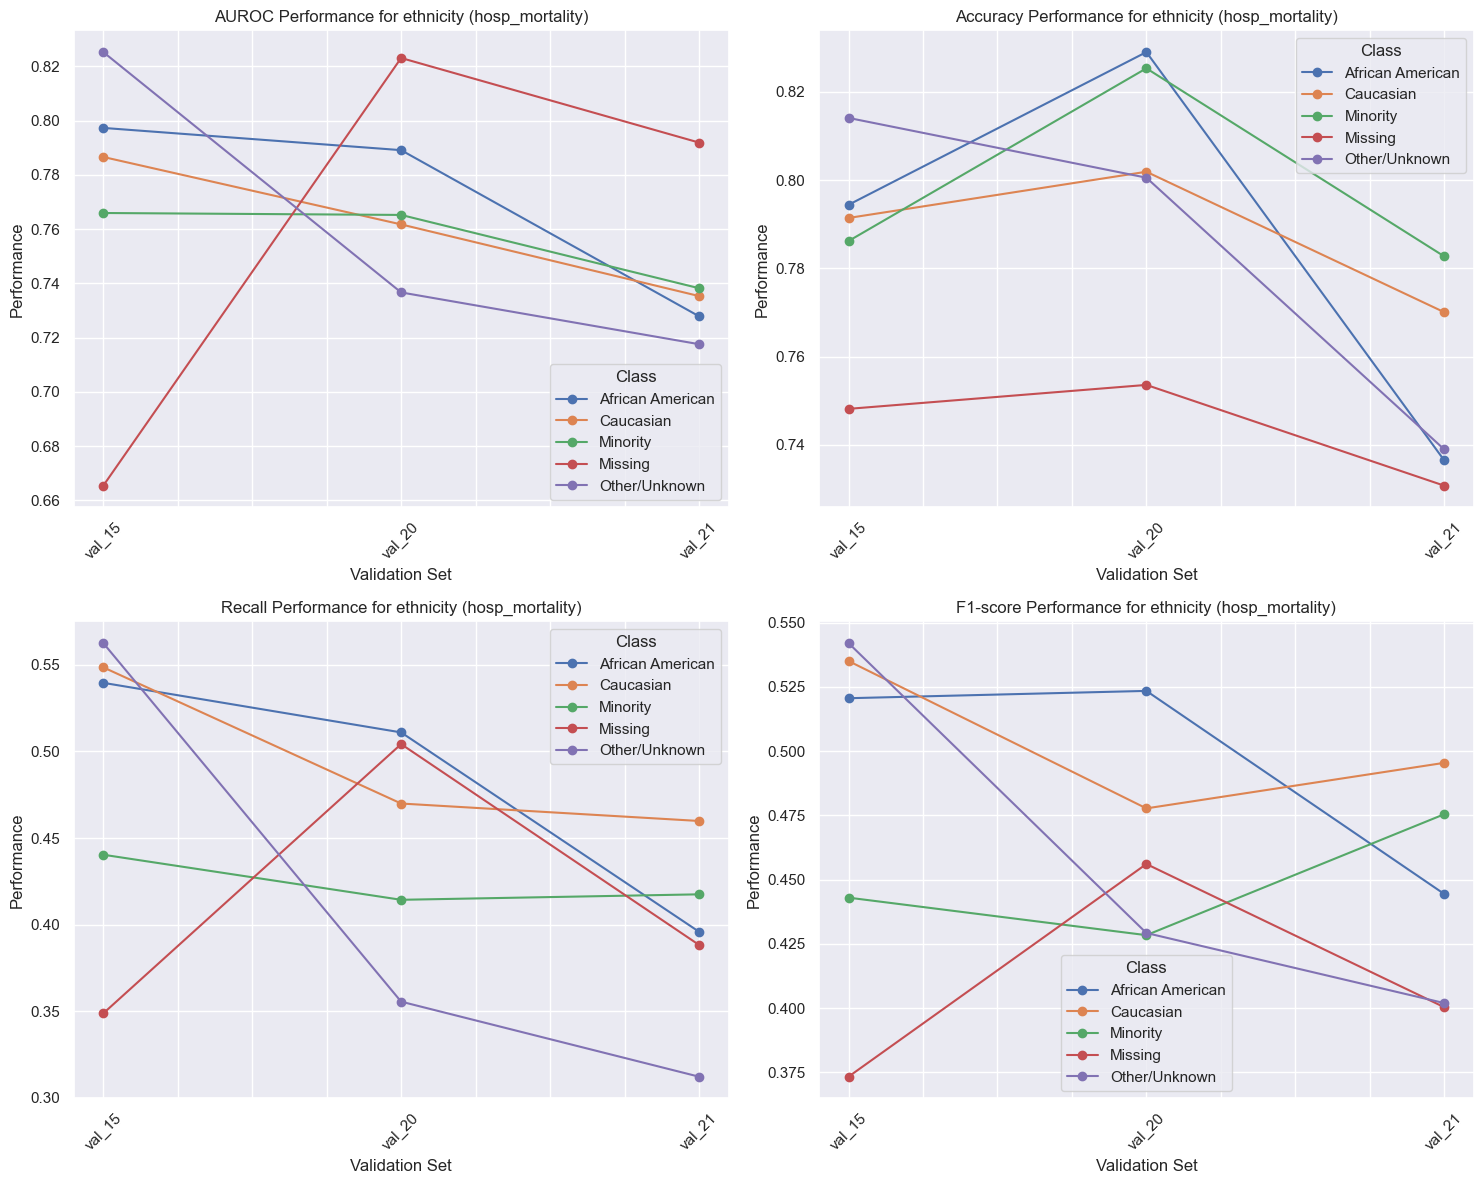

In [126]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))  # 2x2 layout
axes = axes.flatten()  # Flatten the axes array for easy iteration

graph_index = 0  # Index to track the subplot
for metric in metrics:
    for attribute in attributes:
        filtered_df = metrics_all[(metrics_all['Attribute'] == attribute) & (metrics_all['Metric'] == metric)]

        df_grouped = filtered_df[['Task', 'Validation Set', 'Class', 'Value']]
        df_pivot = df_grouped.pivot_table(index='Validation Set', columns='Class', values='Value')

        tasks = df_grouped['Task'].unique()  

        for task in tasks:
            task_df = df_grouped[df_grouped['Task'] == task]  # Filter by task
            task_df_pivot = task_df.pivot_table(index='Validation Set', columns='Class', values='Value')
            
            ax = axes[graph_index]  # Get the current subplot
            task_df_pivot.plot(kind='line', marker='o', ax=ax, title=f"{metric} Performance for {attribute} ({task})")
            ax.set_ylabel('Performance')
            ax.set_xlabel('Validation Set')
            ax.tick_params(axis='x', rotation=45)
            ax.legend(title='Class')
            ax.grid(True)

            graph_index += 1  # Move to the next subplot
            if graph_index >= 4:  # Stop after 4 graphs
                break
        if graph_index >= 4:
            break
    if graph_index >= 4:
        break

plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig("combined_graphs.jpg")  # Save as a single image
plt.show()


In [79]:
metrics_all['Metric'].unique()

array(['AUROC', 'Accuracy', 'Recall', 'F1-score'], dtype=object)

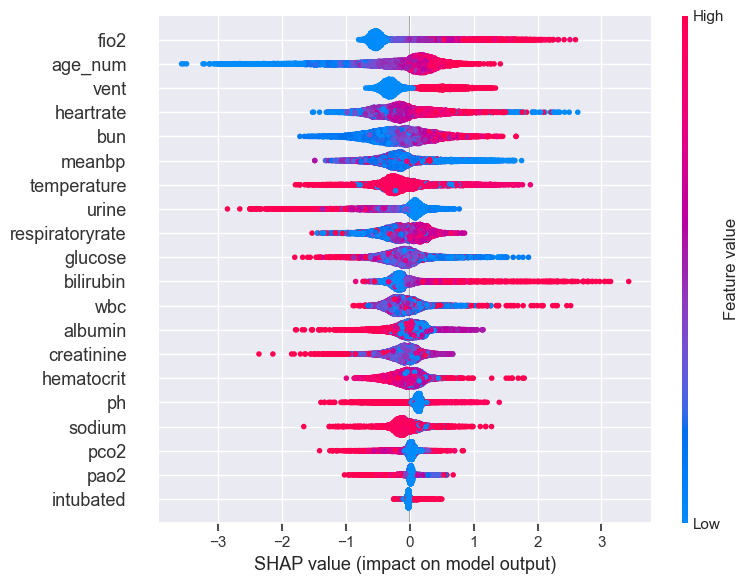

In [80]:
get_explain_plot(fit_model, df.loc[df['set'] == 'train', features])


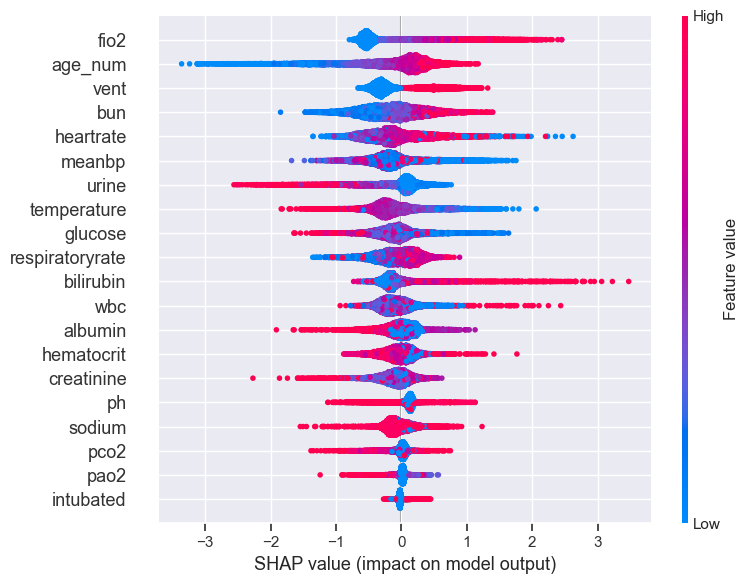

In [81]:
get_explain_plot(fit_model, df.loc[df['set'] == 'val_15', features])


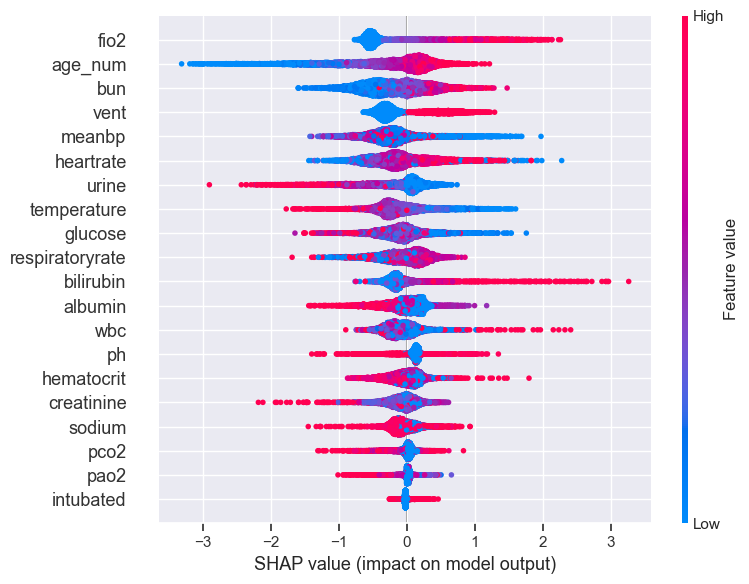

In [113]:
get_explain_plot(fit_model, df.loc[df['set'] == 'val_20', features])


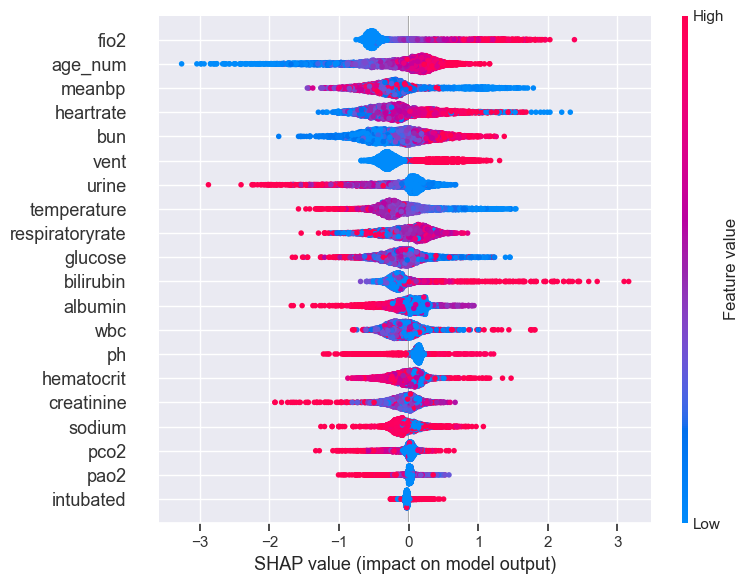

In [114]:
get_explain_plot(fit_model, df.loc[df['set'] == 'val_21', features])
